In [1]:
# The gp_sfh.py file conta"ins a simple GP framework that we'll be using
from gp_sfh import *
from gp_sfh_kernels import *

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from copy import deepcopy
import hickle

import fsps
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
import pandas as pd
import corner

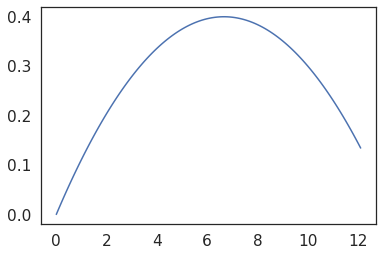

In [50]:
tarr = np.arange(0,cosmo.age(0.1).value,0.1)

plt.plot(tarr, (0.3*(-0.03*tarr**2 + 0.4*tarr + 0.0)))

In [81]:
print(np.sqrt(sigma_fun(cosmo.age(0.1).value)))

0.3575570427201212


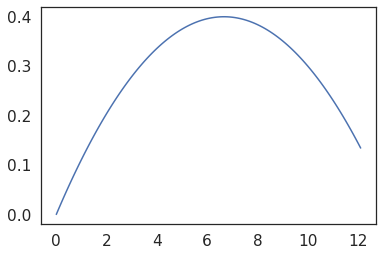

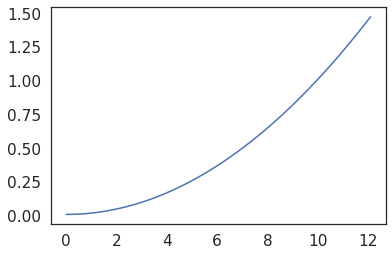

In [72]:
def sigma_fun(t):
    #return 0.6*(-0.01*t**2 + 0.1*t + 1.0)
    return 0.3*(-0.03*t**2 + 0.4*t + 0.0)
    #return 0.3*(-0.03*t**2 + 0.2*t + 0.6*4)

def tau_eq_fun(t):
    return 0.01*t**2+0.01


plt.plot(tarr, sigma_fun(tarr))
plt.show()

plt.plot(tarr, tau_eq_fun(tarr))
plt.show()

In [73]:
def timedep_kernel(t, tp, kernel_params, base_e_to_10 = False):
    """
    A basic implementation of the regulator model kernel, with five parameters:
    kernel_params = [sigma, tau_eq, tau_in, sigma_gmc, tau_gmc]
    sigma: \sigma, the amount of overall variance
    tau_eq: equilibrium timescale
    tau_x: inflow correlation timescale (includes 2pi factor)
    sigma_gmc: gmc variability
    tau_l: cloud lifetime

    """

    #sigma, tau_eq, tau_in, sigma_gmc, tau_gmc = kernel_params
    _, _, tau_in, sigma_gmc, tau_gmc = kernel_params

    if base_e_to_10 == True:
        # in TCF20, this is defined in base e, so convert to base 10
        sigma = sigma*np.log10(np.e)
        sigma_gmc = sigma_gmc*np.log10(np.e)

    tau = np.abs(t-tp)

    if tau_in == tau_eq_fun(t):
        c_reg = sigma_fun(t)**2 * (1 + tau/tau_eq_fun(t)) * (np.exp(-tau/tau_eq_fun(t)))
    else:
        c_reg = sigma_fun(t)**2 / (tau_in - tau_eq_fun(t)) * (tau_in*np.exp(-tau/tau_in) - tau_eq_fun(t)*np.exp(-tau/tau_eq_fun(t)))

    c_gmc = sigma_gmc**2 * np.exp(-tau/tau_gmc)

    kernel_val = (c_reg + c_gmc)
    return kernel_val


In [74]:
nsamp = 1000
tarr_res = 1000
zval = 0.1
random_seed = 42

cases = ['MW_timedep']
case_params = [kernel_params_MW_TCF20]

i=0
case = cases[i]

case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
case1.get_tarr(n_tarr = tarr_res)
#case1.get_basesfh(sfhtype='MS', mstar = 10.0)
case1.get_basesfh(sfhtype='const')
case1.kernel = timedep_kernel


case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, stationary=False,
                                    force_cov=True, kernel_params = case_params[i])

case1.get_spec(nsamp = nsamp)
case1.calc_spectral_features(massnorm = True)

#fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
#hickle.dump(case1, fname)


100%|██████████| 1000/1000 [00:00<00:00, 13620.66it/s]


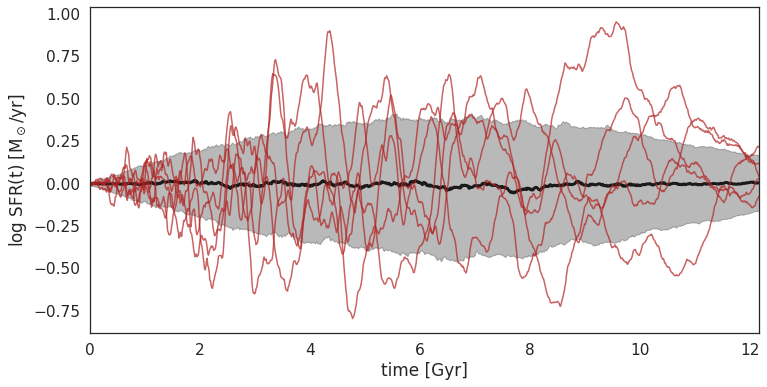

In [78]:
plt.figure(figsize=(12,6))
plt.plot(case1.tarr, np.nanmedian(case1.samples,0),color='k',lw=3)
plt.fill_between(case1.tarr, np.nanpercentile(case1.samples,16,0),
                np.nanpercentile(case1.samples,84,0),alpha=0.3,color='k')

plt.plot(case1.tarr, case1.samples[0:5,0:].T,color='firebrick',alpha=0.7)
plt.xlabel('time [Gyr]')
plt.ylabel('log SFR(t) [M$_\odot$/yr]')
plt.xlim(0,np.amax(case1.tarr))
plt.savefig('figures/nonstationary_kernel.png',bbox_inches='tight')
plt.show()

In [116]:
import matplotlib

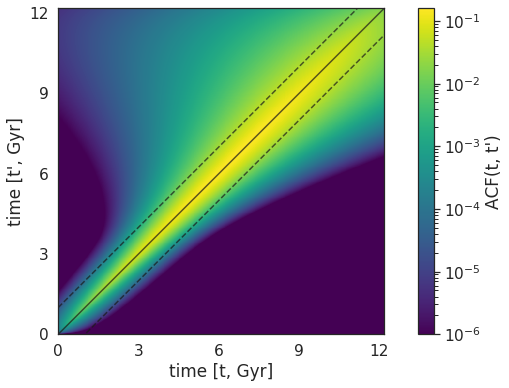

In [127]:
timevals = [0,3,6,9,12]

pltxticks = [np.argmin(np.abs(case1.tarr - timevals[i])) for i in range(len(timevals))]
pltxticklabels = timevals

index_1gyr = np.argmin(np.abs(case1.tarr - 1.0))
tmep = case1.covariance_matrix.copy()
tmep[tmep<1e-6] = 1e-6

plt.figure(figsize=(12,6))
plt.imshow(tmep, origin='lower',cmap='viridis',norm=matplotlib.colors.LogNorm())
plt.plot([0,len(case1.tarr)],[0,len(case1.tarr)],'k-', alpha=0.7)
plt.plot([0,len(case1.tarr)],[0-index_1gyr,len(case1.tarr)-index_1gyr],'k--', alpha=0.7)
plt.plot([0,len(case1.tarr)],[0+index_1gyr,len(case1.tarr)+index_1gyr],'k--', alpha=0.7)
plt.axis([0,len(case1.tarr),0,len(case1.tarr)])
plt.xticks(pltxticks,pltxticklabels)
plt.yticks(pltxticks,pltxticklabels)
plt.xlabel('time [t, Gyr]');plt.ylabel('time [t\', Gyr]')
clbr = plt.colorbar(); clbr.set_label('ACF(t, t\')')
plt.savefig('figures/timedep_ACF.png',bbox_inches='tight')
plt.show()

array([0.        , 3.04446606, 6.08893213, 9.13339819])